# Intoduction:

## Movie Recommendation
In this Notebook I have created a Movie Recommendation Sysytem

* My linkedin id : [Saurabh Maulekhi](https://www.linkedin.com/in/saurabh-maulekhi-326584241/)
* [Model Web Deployment](https://huggingface.co/spaces/saurabh091/LLM_and_Similarity_Based_Media_Recommendation_System)
* [Github Repo](https://github.com/Saurabh-Maulekhi/LLM-and-Similarity-Based-Media-Recommendation-System)
* [Music Recommendation Deployment](https://www.kaggle.com/code/saurabhmaulekhi/music-recommendation)
* [Book Recommendation Deployment](https://www.kaggle.com/code/saurabhmaulekhi/book-recommendations)

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import ast
import requests
from IPython.display import Image, display
from tqdm.auto import tqdm
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from sklearn.metrics.pairwise import cosine_similarity

# Data Cleaning

In [ ]:
movies = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')
credits = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv')

In [ ]:
print("movies shape: ", movies.shape,"\n")
movies.head(1)

In [ ]:
print("Credits shape: ", credits.shape,"\n")
credits.head(1)

### Creating a Function to get the Movie Thumbnail/Poster

In [ ]:
API_KEY = "739e7d39"  # This Api key is disabled get you own key from omdb website
BASE_URL = "http://www.omdbapi.com/"

def get_movie_poster(movie_name):
    """
    args: movie name 
    returns: movie poster link
    """
    
    params = {
        "t": movie_name,
        "apikey": API_KEY
    }
    response = requests.get(BASE_URL, params=params).json()
    
    if response["Response"] == "True":
        poster_url = response["Poster"]
        
        if poster_url and poster_url != "N/A":
            # display(Image(url=poster_url))  # Display the poster
            return poster_url
        else:
            return None
    else:
        return None

# Example usage
movie_name = "Avatar"
poster_url = get_movie_poster(movie_name)
print(poster_url)

In [ ]:
tqdm.pandas()
movies["Thumbnail"] = movies['original_title'].progress_apply(get_movie_poster)

## Merging the Movies and Credits DataFrame

In [ ]:
movies = movies.merge(credits, on="title")

In [ ]:
print("movies shape: ", movies.shape,"\n")
movies.head(1)

## Selecting the important columns for our Recommendation

In [ ]:
# impotant columns that will be used as tags
tag_columns = ['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew', 'Thumbnail']

# new variable containing movie data frame having tags columns
movies = movies[tag_columns]

movies.head()

In [ ]:
movies.info()

In [ ]:
movies.isnull().sum()

In [ ]:
movies.dropna(inplace=True) ## dropping the null rows

In [ ]:
movies.duplicated().sum() ## Retriving duplicate values sum

In [ ]:
movies.iloc[0]['genres'] ## genres list at 1st row

In [ ]:
# It safely evaluates an expression node or a string containing a Python literal.

ast.literal_eval('[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]')

In [ ]:
def convert(obj):
    """
    Converting String dictionary into a list.
    """
    L = []
    for i in ast.literal_eval(obj):  ## this function convert string list into list i.e. "[1,2,3]" => [1,2,3] 
        L.append(i['name'])
    return L

In [ ]:
movies['genres'] = movies['genres'].apply(convert)
movies.head()

In [ ]:
movies['keywords'] = movies['keywords'].apply(convert)
movies.head()

In [ ]:
def convert_cast(obj):
    """
    Giving 3 actors from the 
    cast string dictionary.
    """
    L = []
    counter = 0
    for i in ast.literal_eval(obj):
        if counter != 3:
            L.append(i['name'])
            counter+=1
        else:
            break
    return L

In [ ]:
movies["cast"] = movies["cast"].apply(convert_cast)

movies.head()

In [ ]:
def fetch_director(obj):
    """
    Find director from the
    string dictionary of crew.
    """
    L = []
    for i in ast.literal_eval(obj):
        if( i['job'] == 'Director'):
            L.append(i['name'])
            break
    return L

In [ ]:
movies['crew'] = movies['crew'].apply(fetch_director)
movies.head()

In [ ]:
movies['overview'] = movies['overview'].apply(lambda x:x.split())
movies.head()

In [ ]:
movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ","") for i in x]) ## Removing space from the text 
movies['keywords'] = movies['keywords'].apply(lambda x:[i.replace(" ","") for i in x]) ## Removing space from the text 
movies['cast'] = movies['cast'].apply(lambda x:[i.replace(" ","") for i in x]) ## Removing space from the text 
movies['crew'] = movies['crew'].apply(lambda x:[i.replace(" ","") for i in x]) ## Removing space from the text 

In [ ]:
movies.head()

In [ ]:
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew'] ## conactenating all tags columns and creating a new column from it

In [ ]:
movies.head()

In [ ]:
new_df = movies[["movie_id", "title", "tags","Thumbnail"]]

In [ ]:
new_df.head()

In [ ]:
new_df['tags'] = new_df['tags'].apply(lambda x:" ".join(x)) ## Removing space from the text 

In [ ]:
new_df.head()

In [ ]:
ps = PorterStemmer()  ## This function returns the base or root form of the word

# ex:
[ps.stem("love"), ps.stem("loving"), ps.stem("Loved"), ps.stem("Lovely")]

In [ ]:
def stem(text):
    """
    arg: text 
    return: text with words in their root form 
    """
    y = []
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)

In [ ]:
new_df['tags'] = new_df['tags'].apply(stem)

In [ ]:
new_df['tags'][0]

In [ ]:
new_df['tags'] = new_df['tags'].apply(lambda x:x.lower()) #converting text into lower case

In [ ]:
 new_df.head()

In [ ]:
new_df['tags'][0]

## Vectorization of Text using Bag of Words technique

In [ ]:
cv = CountVectorizer(max_features=50000, stop_words='english')  #model for vectorization

In [ ]:
vectors = cv.fit_transform(new_df['tags']).toarray() ## fitting vectorization model and cerating vectors
vectors

In [ ]:
vectors.shape

In [ ]:
cv.get_feature_names_out() #list of al the words in our vectorization model

# Getting Similarity Score between movies

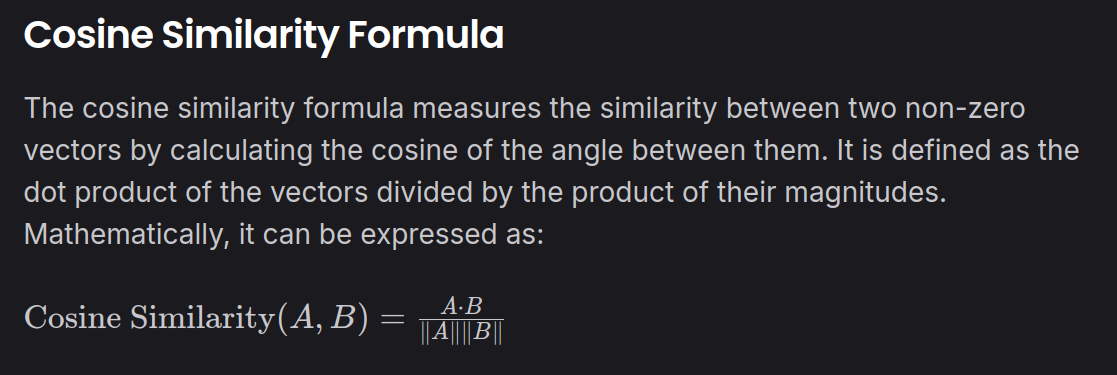

**more simillar score = more similar similar vectors in the plane**

In [ ]:
similarity = cosine_similarity(vectors) ## getting a matrix which have the cosine similarity score between the vectors

In [ ]:
## this show the cosine simliarity scores at index 1
similarity[1]

In [ ]:
similarity.shape

In [ ]:
# This script is sorting the similartiry score in descending order and then getting list of tuples with their index value and similarity score  
sorted(list(enumerate(similarity[0])), reverse=True, key=lambda x:x[1])[1:11]

# Movie Recommend Function

In [ ]:
def recommend(movie):
    movie_index = new_df[new_df['title'] == movie].index[0] ## getting the index of the movie
    distances = similarity[movie_index] ## getting a matrix which have the cosine similarity score between the vectors
    
    # fisrt creating a list of tuples , tuple = (<index> , similarity score)
    # sorting tuples list in desceding order of similarity order
    # third getting index values from index of list 1 to 10[including 10] and storing them in a list . We are not including 0th index because this is the score of highest similarity of moviw with itself , 
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:11]

    # iterating over the recomended movies list which have movie's index values
    for i in movies_list:
        print(new_df.iloc[i[0]].title) ## getting movie title

In [ ]:
recommend('Avatar')

# Dumping the Cleaned Dataset and Similarity Scores

In [ ]:
pickle.dump(new_df,open('movies.pkl','wb'))

In [ ]:
new_df['title'].values

In [ ]:
## saving our new df dataset after converting it into dictionary
pickle.dump(new_df.to_dict(),open('movies_dict.pkl','wb'))

In [ ]:
pickle.dump(similarity, open('similarity.pkl','wb'))

In [ ]:
df = pickle.load(open('/kaggle/working/movies.pkl','rb'))
df.head()